In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from stldecompose import stl
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import defaultdict
import calendar
from math import sqrt
from sklearn.metrics import mean_squared_error

### Cuba Land Temperature
- Date range: Jan 1823 - Sept 2013

In [4]:
cuba = pd.read_csv('data/cuba_temperature.csv')
cuba = cuba[['dt','AverageTemperature']]
cuba['dt'] = pd.to_datetime(cuba['dt'])
cuba = cuba.set_index('dt')

split_idx = int(len(cuba) * 0.8)
cuba_train = cuba[:split_idx]
cuba_test = cuba[split_idx:]
train_X, train_y = cuba_train.index, cuba_train['AverageTemperature']
test_X, test_y = cuba_test.index, cuba_test['AverageTemperature']

In [5]:
cuba.head()

,AverageTemperature
dt,
1823-01-01,22.381
1823-02-01,21.031
1823-03-01,23.771
1823-04-01,24.232
1823-05-01,26.075


C:\Users\user\.conda\envs\mimos\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


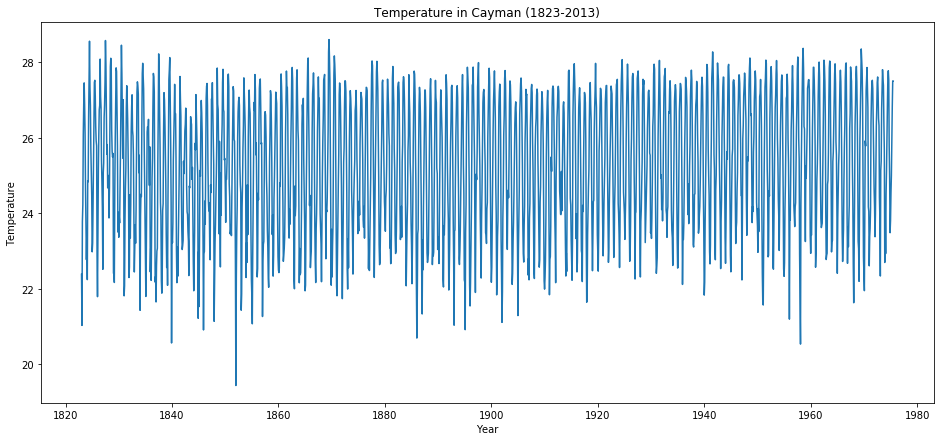

In [6]:
plt.figure(figsize=(16,7))
plt.plot(train_X,train_y)
plt.title('Temperature in Cayman (1823-2013)')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

In [7]:
def dickey_fuller(X):
    dickey = adfuller(X)
    print('ADF Statistic: %f' % dickey[0])
    print('p-value: %f' % dickey[1])
    print('Critical Values:')
    for key, value in dickey[4].items():
        print('\t%s: %.3f' % (key, value))
    return 



### Stationarity test for original time series
1. Dickey-Fuller test has p-value of 0.000186, which is smaller that 1% confidence interval, indicates that the time series is stationary. However, by looking at the time series plot earlier, it shows slightly downward trend from year 1820-1840, this shows that the time series is slightly non-stationary. A regular differencing might be required.
2. The ACF plot shows strong seasonality with 12 months period. A seasonality differencing is required.

ADF Statistic: -4.512831
p-value: 0.000186
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


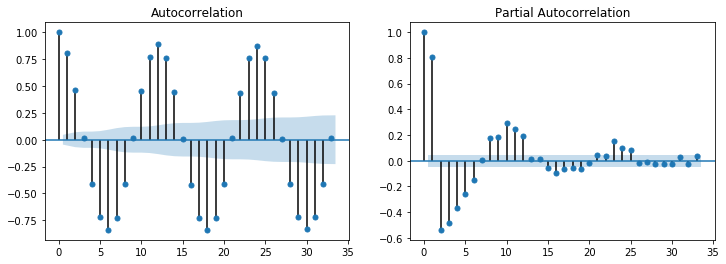

In [8]:
dickey_fuller(train_y)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(train_y, ax[0])
plot_pacf(train_y, ax[1])
plt.show()

### Apply First-differencing

ADF Statistic: -16.353304
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


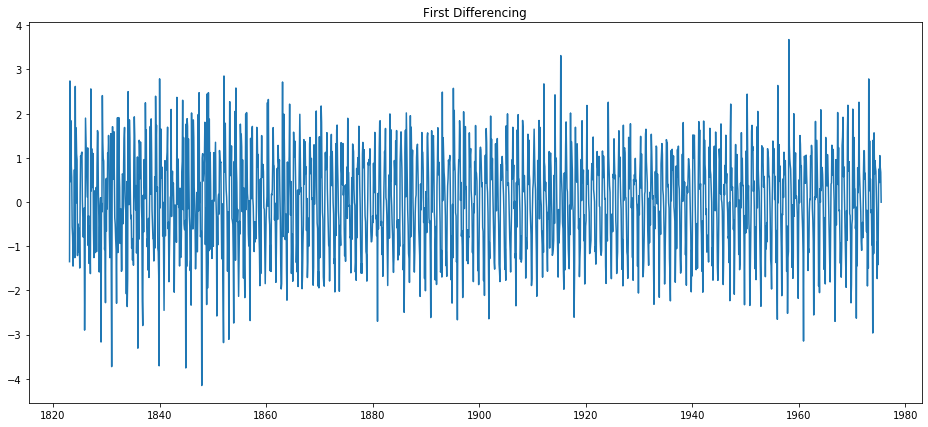

In [9]:
first_diff_df = cuba_train.diff(periods=1,axis=0)
first_diff_df_y = first_diff_df['AverageTemperature'].values[1:]
dickey_fuller(first_diff_df_y)
plt.figure(figsize=(16,7))
plt.title('First Differencing')
plt.plot(train_X[1:],first_diff_df_y)

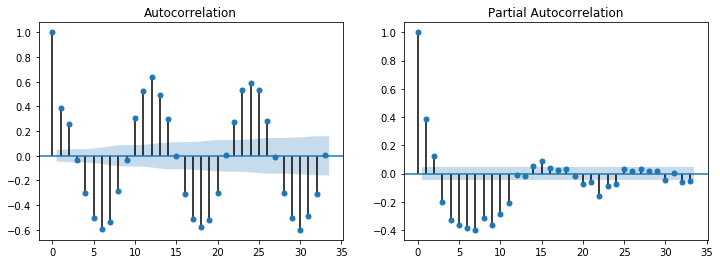

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(first_diff_df_y, ax[0])
plot_pacf(first_diff_df_y, ax[1])
plt.show()

### First differencing (period=12)
- Insights: 
   - the ACF plot shows sharp cut-off at lag-1 -> set Q=1
   - the PACF plot shows sharp cut-off at lag-1 -> set P=1
   - SARIMAX order to be used: (0,0,0)(1,1,1,12)

ADF Statistic: -13.460151
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


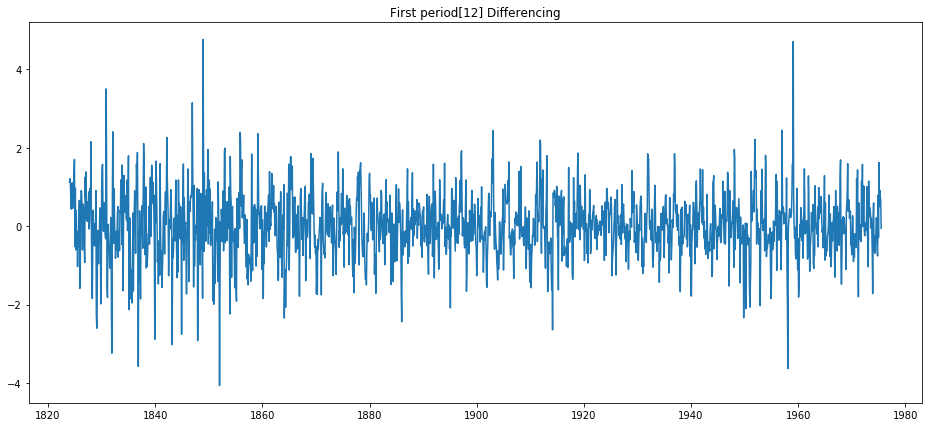

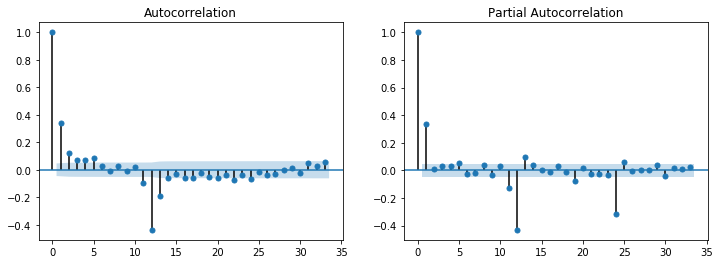

In [15]:
first12_diff_df = cuba_train.diff(periods=12,axis=0)
first12_diff_df_y = first12_diff_df['AverageTemperature'].values[12:]
dickey_fuller(first12_diff_df_y)
plt.figure(figsize=(16,7))
plt.title('First period[12] Differencing')
plt.plot(train_X[12:],first12_diff_df_y)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(first12_diff_df_y, ax[0])
plot_pacf(first12_diff_df_y, ax[1])
plt.show()

### Seasonality check using boxplot
- Prerequisite: time series should be detrend

In [70]:
# x should be in datetime format
def boxplots_by_month(x, y):
    data_by_month = defaultdict(list)
    for i in range(len(x)):
        data_by_month[calendar.month_name[x.month[i]][:3]].append(y[i])
        
    fig, ax = plt.subplots()
    ax.boxplot(data_by_month.values())
    ax.set_xticklabels(data_by_month.keys())
    plt.show()
    return data_by_month

# x should be in datetime format
def boxplots_by_year(x, y, figsize=(12,8)):
    data_by_year = defaultdict(list)
    for i in range(len(x)):
        data_by_year[str(x[i].year)[-2:]].append(y[i])
        
    fig, ax = plt.subplots(figsize=figsize)
    ax.boxplot(data_by_year.values())
    ax.set_xticklabels(data_by_year.keys())
    plt.show()
    return data_by_year    

# x should be in datetime format
def boxplots_by_season(x, y):
    data_by_season = defaultdict(list)
    for i in range(len(x)):
        # follow USA seasons
        if x.month[i] in [3,4,5]:
            season = 'Spring'
        elif x.month[i] in [6,7,8]:
            season = 'Summer'
        elif x.month[i] in [9,10,11]:
            season = 'Autumn'
        else:
            season = 'Winter'            
        data_by_season[season].append(y[i])
        
    fig, ax = plt.subplots()
    ax.boxplot(data_by_season.values())
    ax.set_xticklabels(data_by_season.keys())
    plt.show()
    return data_by_season  

- Insights from the following plot: The median and quartile range varies per boxplot, showing seasonality of 12 periods

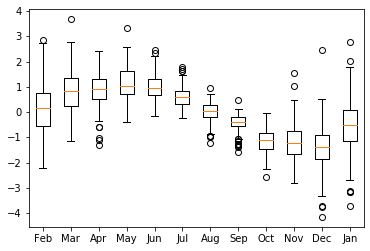

In [71]:
first_diff_co2_by_month = boxplots_by_month(train_X[1:],first_diff_df_y)

### 1. SARIMAX (0,0,0)(1,1,1,12)
- Result analysis: 
  - The ACF plot shows decaying pattern which indicates the time series is underdifferenced


C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.S.L12    0.084555
ma.S.L12   -0.936375
sigma2      0.395776
dtype: float64
                            Statespace Model Results                            
Dep. Variable:       AverageTemperature   No. Observations:                 1831
Model:             SARIMAX(1, 1, 1, 12)   Log Likelihood               -1749.653
Date:                  Mon, 27 Jan 2020   AIC                           3505.306
Time:                          23:04:23   BIC                           3521.824
Sample:                      01-01-1823   HQIC                          3511.400
                           - 07-01-1975                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0846      0.019      4.429      0.000       0.047       0.122
ma.S.L12      -0.9364      0.009   -1

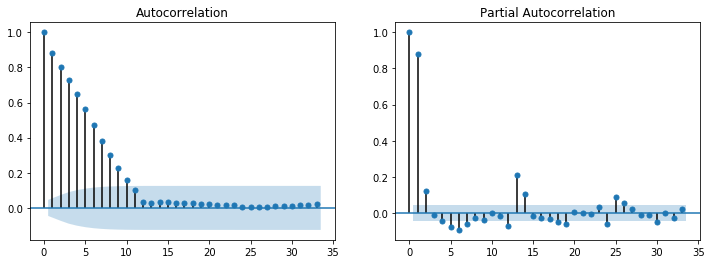

In [16]:
sarima000011 = SARIMAX(train_y, order=(0,0,0), seasonal_order=(1,1,1,12)).fit()
print(sarima000011.params)
print(sarima000011.summary())
sarima000011_res = pd.DataFrame(sarima000011.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima000011_res, ax[0])
plot_pacf(sarima000011_res, ax[1])
plt.show()

### Second differencing (period=12)
- Insights: 
  - ACF plot shows non-signinficant cut-off at lag-2 -> set Q=2 or Q=1
  - PACF plot shows decaying pattern -> set P=0

ADF Statistic: -14.409168
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


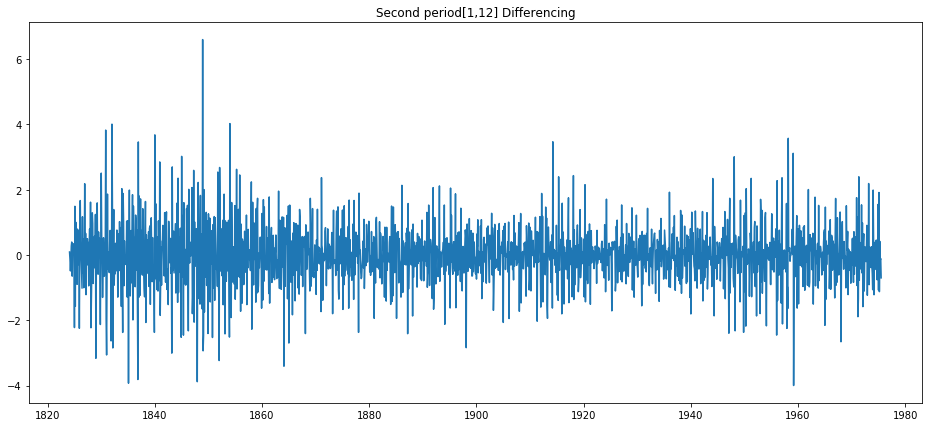

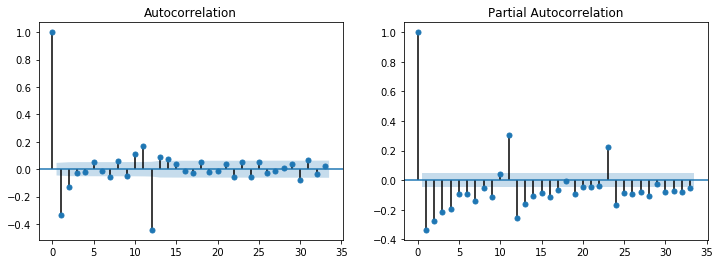

In [17]:
sec12_diff_df = first_diff_df.diff(periods=12,axis=0)
sec12_diff_df_y = sec12_diff_df['AverageTemperature'].values[13:]
dickey_fuller(sec12_diff_df_y)
plt.figure(figsize=(16,7))
plt.title('Second period[1,12] Differencing')
plt.plot(train_X[13:],sec12_diff_df_y)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sec12_diff_df_y, ax[0])
plot_pacf(sec12_diff_df_y, ax[1])
plt.show()

### SARIMAX (0,1,0)(0,1,2,12)

C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ma.S.L12   -0.914568
ma.S.L24   -0.062287
sigma2      0.488555
dtype: float64
3899.381115143027
                                 Statespace Model Results                                 
Dep. Variable:                 AverageTemperature   No. Observations:                 1831
Model:             SARIMAX(0, 1, 0)x(0, 1, 2, 12)   Log Likelihood               -1946.691
Date:                            Mon, 27 Jan 2020   AIC                           3899.381
Time:                                    23:10:24   BIC                           3915.898
Sample:                                01-01-1823   HQIC                          3905.475
                                     - 07-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9

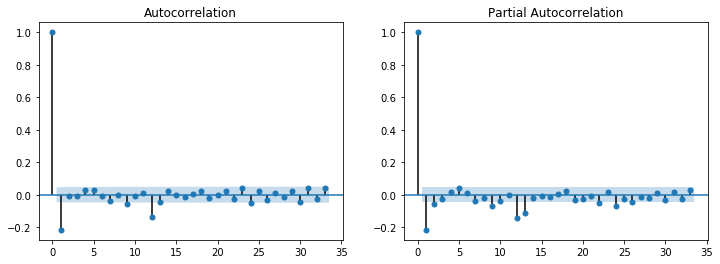

In [18]:
sarima010012 = SARIMAX(train_y, order=(0,1,0), seasonal_order=(0,1,2,12)).fit()
print(sarima010012.params)
print(sarima010012.aic)
print(sarima010012.summary())
sarima010012_res = pd.DataFrame(sarima010012.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima010012_res, ax[0])
plot_pacf(sarima010012_res, ax[1])
plt.show()

### SARIMAX (1,1,1)(0,1,1)
- ACF and PACF plots have most of the points within 95% confidence interval
- The model fits the data

C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                 AverageTemperature   No. Observations:                 1831
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1607.003
Date:                            Mon, 27 Jan 2020   AIC                           3222.007
Time:                                    23:28:14   BIC                           3244.029
Sample:                                01-01-1823   HQIC                          3230.132
                                     - 07-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3348      0.019     17.770      0.000       0.298       0.372
ma.L1         -0.9752      0.006   

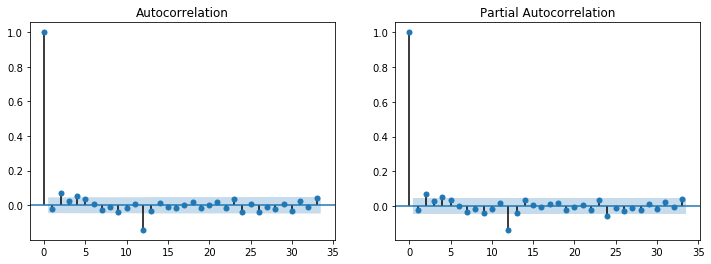

In [24]:
sarima010011 = SARIMAX(train_y, order=(1,1,1), seasonal_order=(0,1,1,12)).fit()
print(sarima010011.summary())
sarima010011_res = pd.DataFrame(sarima010011.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima010011_res, ax[0])
plot_pacf(sarima010011_res, ax[1])
plt.show()

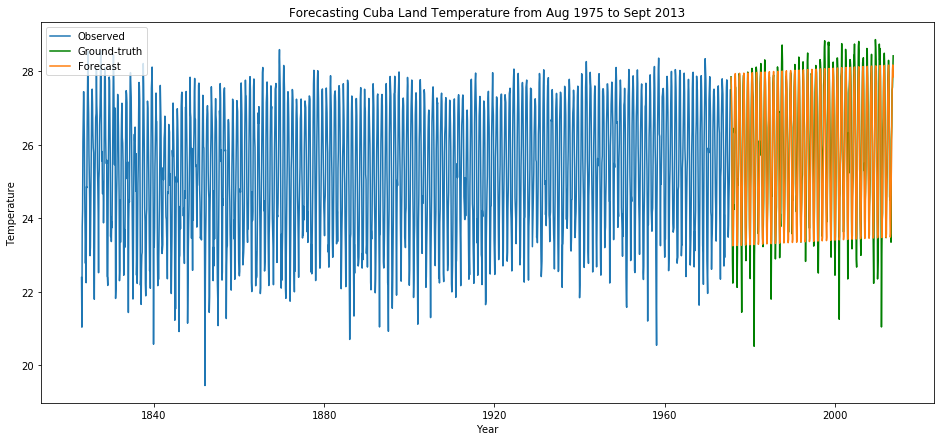

In [42]:
sarima010011_prediction = sarima010011.predict(start=test_X[0], end=test_X[-1])
sarima010011_prediction_ = [0]*(len(train_X)) + list(sarima010011_prediction)
sarima010011_prediction_ = np.ma.masked_where([i<split_idx for i in range(len(train_X)+len(test_X))], np.asarray(sarima010011_prediction_)) 

observed = list(train_y)+[0]*len(test_y)
observed_masked = np.ma.masked_where([i>=split_idx for i in range(len(train_X)+len(test_X))], observed)

gtruth = [0]*len(train_y) + list(test_y)
gtruth_masked = np.ma.masked_where([i<split_idx for i in range(len(train_X)+len(test_X))], gtruth)

plt.figure(figsize=(16,7))
plt.plot(np.concatenate((train_X,test_X)), observed_masked, label='Observed')
plt.plot(np.concatenate((train_X,test_X)), gtruth_masked, label='Ground-truth', color='green')
plt.plot(np.concatenate((train_X,test_X)), sarima010011_prediction_, label='Forecast')
plt.legend(loc='upper left')
plt.title('Forecasting Cuba Land Temperature from Aug 1975 to Sept 2013')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

In [41]:
print(test_X[0])
test_X[-1]

1975-08-01 00:00:00


Timestamp('2013-09-01 00:00:00')

In [32]:
sarima010011_rmse = sqrt(mean_squared_error(test_y, sarima010011_prediction))
print('RMSE: ', sarima010011_rmse)

RMSE:  0.612971892075376


### SARIMAX (1,1,1)(0,1,2)
- ACF and PACF plots have most of the points within 95% confidence interval
- The model fits the data

C:\Users\user\.conda\envs\mimos\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.L1       0.340163
ma.L1      -0.979365
ma.S.L12   -0.911860
ma.S.L24   -0.062686
sigma2      0.334329
dtype: float64
3217.907313090299
                                 Statespace Model Results                                 
Dep. Variable:                 AverageTemperature   No. Observations:                 1831
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -1603.954
Date:                            Mon, 27 Jan 2020   AIC                           3217.907
Time:                                    23:12:06   BIC                           3245.435
Sample:                                01-01-1823   HQIC                          3228.064
                                     - 07-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

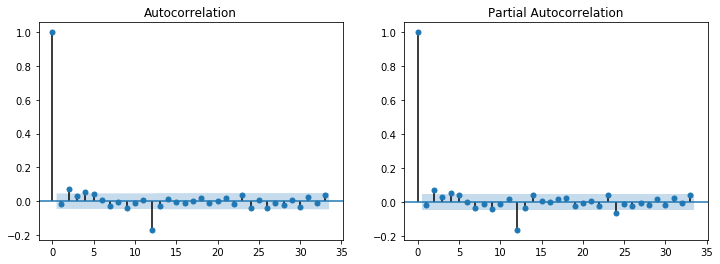

In [19]:
sarima111012 = SARIMAX(train_y, order=(1,1,1), seasonal_order=(0,1,2,12)).fit()
print(sarima111012.params)
print(sarima111012.aic)
print(sarima111012.summary())
sarima111012_res = pd.DataFrame(sarima111012.resid)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(sarima111012_res, ax[0])
plot_pacf(sarima111012_res, ax[1])
plt.show()

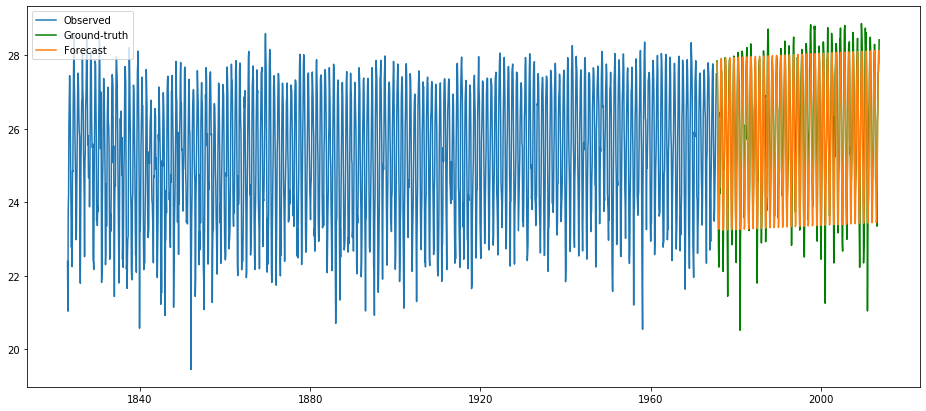

In [20]:
sarima111012_prediction = sarima111012.predict(start=test_X[0], end=test_X[-1])
sarima111012_prediction_ = [0]*(len(train_X)) + list(sarima111012_prediction)
sarima111012_prediction_ = np.ma.masked_where([i<split_idx for i in range(len(train_X)+len(test_X))], np.asarray(sarima111012_prediction_)) 

observed = list(train_y)+[0]*len(test_y)
observed_masked = np.ma.masked_where([i>=split_idx for i in range(len(train_X)+len(test_X))], observed)

gtruth = [0]*len(train_y) + list(test_y)
gtruth_masked = np.ma.masked_where([i<split_idx for i in range(len(train_X)+len(test_X))], gtruth)

plt.figure(figsize=(16,7))
plt.plot(np.concatenate((train_X,test_X)), observed_masked, label='Observed')
plt.plot(np.concatenate((train_X,test_X)), gtruth_masked, label='Ground-truth', color='green')
plt.plot(np.concatenate((train_X,test_X)), sarima111012_prediction_, label='Forecast')
plt.legend(loc='upper left')
plt.show()

In [48]:
sarima111012_rmse = sqrt(mean_squared_error(test_y, sarima111012_prediction))
print('RMSE: ', sarima111012_rmse)

RMSE:  0.621138252703446


--------------------------------------------------------------------------------------------------------------------
## Conclusion
- Comparison between SARIMAX(1,1,1)(0,1,1,12) and SARIMAX(1,1,1)(0,1,2,12):
  - AIC: 3222 vs 3217
  - BIC: 3244 vs 3245
  - RMSE: 0.6130 VS 0.6211
- Both models have nearly same AIC, BIC and RMSE. Model with lower parameter orders and lower prediction error (RMSE) will be selected: SARIMAX(1,1,1)(0,1,1,12)